In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns

In [2]:
df = pd.read_csv('News_dataset.csv')
df.head()

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
0,1,389c669730cb6c54314a46be785cea42,"THĂNG CẤP BẬC HÀM ĐỐI VỚI 2 CÁN BỘ, CHIẾN SỸ H...",2020-04-03 20:23:59,19477.0,378.0,173.0,0
1,2,775baa6d037b6d359b229a656eaeaf08,<URL>,2020-05-08 11:59:26,11.0,5.0,3.0,0
2,3,b9f3394d2aff86d85974f5040c401f08,TƯ VẤN MÙA THI: Cách nộp hồ sơ để trúng tuyển ...,2020-06-06 01:00:13,48.0,5.0,19.0,0
3,4,808e278b22ec6b96f2faf7447d10cd8e,Cơ quan Cạnh tranh và Thị trường Anh quyết địn...,2020-06-13 04:46:53,3.0,0.0,0.0,0
4,5,f81bdd6d8be4c5f64bb664214e47aced,Thêm 7 ca tại Quảng Nam liên quan đến hành khá...,2020-03-09 07:02:38,775.0,0.0,54.0,0


Số lượng tin trong dữ liệu: 4868 

label
0    4050
1     818
dtype: int64 



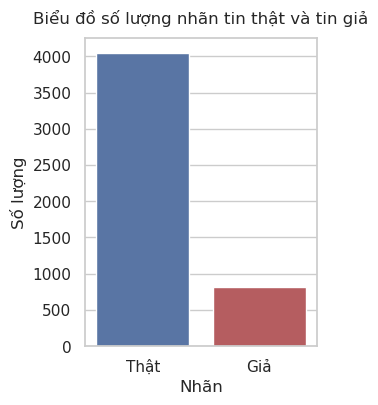

In [3]:
# Count of each label
label_count = df.value_counts('label')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(3, 4))
sns.barplot(x=['Thật', 'Giả'], y=label_count, palette=['b', 'r'])
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.title('Biểu đồ số lượng nhãn tin thật và tin giả', y=1.02) # y = space from graph
print('Số lượng tin trong dữ liệu:', len(df['label']), '\n')
print(label_count, '\n')

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")

ids_list = []
for i, sequence in enumerate(df['post_message']):
    tokens = tokenizer.tokenize(sequence)
    ids = tokenizer.convert_tokens_to_ids(tokens)
    ids_list.append(ids)
df['encoding'] = ids_list

/home/ubuntu/miniconda3/envs/tsai_ecg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df.head()

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label,encoding
0,1,389c669730cb6c54314a46be785cea42,"THĂNG CẤP BẬC HÀM ĐỐI VỚI 2 CÁN BỘ, CHIẾN SỸ H...",2020-04-03 20:23:59,19477.0,378.0,173.0,0,"[2077, 6599, 2799, 129, 1245, 1683, 232, 5751,..."
1,2,775baa6d037b6d359b229a656eaeaf08,<URL>,2020-05-08 11:59:26,11.0,5.0,3.0,0,"[4787, 31771, 15690]"
2,3,b9f3394d2aff86d85974f5040c401f08,TƯ VẤN MÙA THI: Cách nộp hồ sơ để trúng tuyển ...,2020-06-06 01:00:13,48.0,5.0,19.0,0,"[4425, 291, 1245, 904, 315, 5440, 1352, 23, 94..."
3,4,808e278b22ec6b96f2faf7447d10cd8e,Cơ quan Cạnh tranh và Thị trường Anh quyết địn...,2020-06-13 04:46:53,3.0,0.0,0.0,0,"[1221, 65, 129, 1443, 479, 6, 554, 78, 242, 24..."
4,5,f81bdd6d8be4c5f64bb664214e47aced,Thêm 7 ca tại Quảng Nam liên quan đến hành khá...,2020-03-09 07:02:38,775.0,0.0,54.0,0,"[2824, 582, 506, 34, 877, 70, 262, 65, 30, 93,..."


In [6]:
standard_new = []
fake_new = []

for i, encoding in enumerate(df['encoding']):
    if df.loc[i, 'label'] == 0:
        standard_new.append(encoding)
    elif df.loc[i, 'label'] == 1:
        fake_new.append(encoding)


In [7]:
from sklearn.model_selection import train_test_split
X = standard_new + fake_new

# Create the corresponding labels (0 for standard and 1 for fake)
Y = [0] * len(standard_new) + [1] * len(fake_new)

# Split the data into training and test sets (80% - 20%), ensuring balance in classes
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)

# Print the sizes of the training and test sets
print("Size of X_train:", len(X_train))
print("Size of X_test:", len(X_test))
print("Size of Y_train:", len(Y_train))
print("Size of Y_test:", len(Y_test))

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
X_train = [torch.tensor(x) for x in X_train]
padded_X_train = rnn_utils.pad_sequence(X_train, batch_first=True)

X_test = [torch.tensor(x) for x in X_test]
padded_X_test = rnn_utils.pad_sequence(X_test, batch_first=True)

Size of X_train: 4381
Size of X_test: 487
Size of Y_train: 4381
Size of Y_test: 487


In [8]:
X_train = padded_X_train
X_test = padded_X_test
Y_train = torch.tensor(Y_train, dtype=torch.long)  
Y_test = torch.tensor(Y_test, dtype=torch.long)

In [9]:
X_train.shape

torch.Size([4381, 7180])

In [10]:
from torch.nn import Module

class LSTMClassifier(Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x.size(0), x.cuda())
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, batch_size, device):
        h0 = torch.randn(self.layer_dim, batch_size, self.hidden_dim).cuda()
        c0 = torch.randn(self.layer_dim, batch_size, self.hidden_dim).cuda()
        h0 = to_float32(h0)
        c0 = to_float32(c0)
        return h0, c0

In [11]:
def to_float32(tensor):
    return tensor.to(torch.float32)

X_train = to_float32(X_train)
Y_train = to_float32(Y_train)
X_test = to_float32(X_test)
Y_test = to_float32(Y_test)

In [12]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(X_train, Y_train)
valid_ds = TensorDataset(X_test, Y_test)
train_dl=DataLoader(train_ds, batch_size=16)
valid_dl=DataLoader(valid_ds, batch_size=16)

In [13]:
from torch.optim.lr_scheduler import _LRScheduler
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]


def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

In [15]:
input_dim = 1
hidden_dim = 256
layer_dim = 3
output_dim = 1
seq_dim = 128

lr = 0.0005
n_epochs = 1000
iterations_per_epoch = len(train_dl)
best_acc = 0
patience, trials = 100, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    for i, (x_batch, y_batch) in enumerate(train_dl):
        model.train()
        
        x_batch = x_batch.reshape([x_batch.shape[0], x_batch.shape[1], 1])
        y_batch = y_batch.reshape([y_batch.shape[0]])
        
        x_batch = to_float32(x_batch)
        y_batch = to_float32(y_batch)
        
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        
        y_batch = y_batch.reshape(-1,1)
        sched.step()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in valid_dl:
        x_val = x_val.reshape([x_batch.shape[0], x_batch.shape[1], 1])
        y_val = y_val.reshape([y_val.shape[0]])
        
        x_val = to_float32(x_val)
        y_val = to_float32(y_val)
        
        x_val = x_val.cuda()
        y_val = y_val.cuda()
        
        y_val = y_val.reshape(-1,1)
        
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
    
    acc = correct / total

    if epoch % 5 == 0:
        print(f'Epoch: {epoch}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training


/home/ubuntu/miniconda3/envs/tsai_ecg/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


OutOfMemoryError: CUDA out of memory. Tried to allocate 118.00 MiB (GPU 0; 23.70 GiB total capacity; 2.21 GiB already allocated; 74.81 MiB free; 2.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF